# HISTORY OF F1: DATA ANALYSIS OF THE PREMIER MOTORSPORT CHAMPIONSHIP AND USING MACHINE LEARNING TO PREDICT THE CHAMPIONSHIP STANDINGS.

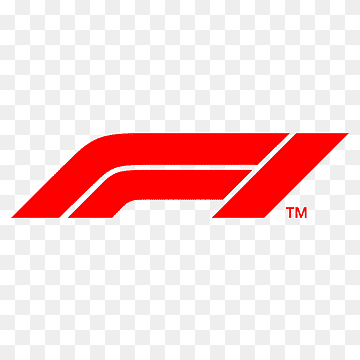

IMPORTING LIBRARIES, LOADING 14 CSV FILES, DROPPING REDUNDANT/UNNECESSARY COLUMNS, MERGING 14 DATAFRAMES AND HANDLING MISSING VALUES.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import gaussian_kde
import pickle

In [2]:
races_df = pd.read_csv('races.csv')
circuits_df = pd.read_csv('circuits.csv')
constructor_results_df = pd.read_csv('constructor_results.csv')
constructor_standings_df = pd.read_csv('constructor_standings.csv')
constructors_df = pd.read_csv('constructors.csv')
driver_standings_df = pd.read_csv('driver_standings.csv')
drivers_df = pd.read_csv('drivers.csv')
lap_times_df = pd.read_csv('lap_times.csv')
pit_stops_df = pd.read_csv('pit_stops.csv')
qualifying_df = pd.read_csv('qualifying.csv')
results_df = pd.read_csv('results.csv')
seasons_df = pd.read_csv('seasons.csv')
sprint_results_df = pd.read_csv('sprint_results.csv')
status_df = pd.read_csv('status.csv')

In [3]:
races_df = races_df.drop(columns=['date', 'time', 'url'])
circuits_df = circuits_df.drop(columns=['circuitRef', 'location', 'lat', 'lng', 'alt', 'url'])
constructor_standings_df = constructor_standings_df.drop(columns=['constructorStandingsId', 'positionText'])
constructors_df = constructors_df.drop(columns=['constructorRef', 'url'])
driver_standings_df = driver_standings_df.drop(columns=['driverStandingsId', 'positionText'])
drivers_df = drivers_df.drop(columns=['forename', 'dob', 'driverRef', 'code', 'url', 'number'])
lap_times_df = lap_times_df.drop(columns=['time'])
pit_stops_df = pit_stops_df.drop(columns=['time'])
qualifying_df = qualifying_df.drop(columns=['qualifyId', 'number'])
results_df = results_df.drop(columns=['resultId', 'positionText', 'position', 'number', 'time'])
seasons_df = seasons_df.drop(columns=['url'])
sprint_results_df = sprint_results_df.drop(columns=['resultId', 'positionText', 'number', 'time'])

In [4]:
dataframes = [results_df, races_df, circuits_df, constructors_df, constructor_results_df, constructor_standings_df, driver_standings_df, drivers_df, lap_times_df, pit_stops_df, qualifying_df, seasons_df, sprint_results_df, status_df]

for df in dataframes:
    df.replace(['NA', '\\N'], np.nan, inplace=True)

print("Replaced 'NA' and '\\N' with NaN in all dataframes.")

print("Missing values in races_df:")
print(races_df.isnull().sum())
print("\nMissing values in circuits_df:")
print(circuits_df.isnull().sum())
print("\nMissing values in constructor_results_df:")
print(constructor_results_df.isnull().sum())
print("\nMissing values in constructor_standings_df:")
print(constructor_standings_df.isnull().sum())
print("\nMissing values in constructors_df:")
print(constructors_df.isnull().sum())
print("\nMissing values in driver_standings_df:")
print(driver_standings_df.isnull().sum())
print("\nMissing values in drivers_df:")
print(drivers_df.isnull().sum())
print("\nMissing values in lap_times_df:")
print(lap_times_df.isnull().sum())
print("\nMissing values in pit_stops_df:")
print(pit_stops_df.isnull().sum())
print("\nMissing values in qualifying_df:")
print(qualifying_df.isnull().sum())
print("\nMissing values in results_df:")
print(results_df.isnull().sum())
print("\nMissing values in seasons_df:")
print(seasons_df.isnull().sum())
print("\nMissing values in sprint_results_df:")
print(sprint_results_df.isnull().sum())
print("\nMissing values in status_df:")
print(status_df.isnull().sum())

Replaced 'NA' and '\N' with NaN in all dataframes.
Missing values in races_df:
raceId            0
year              0
round             0
circuitId         0
name              0
fp1_date       1035
fp1_time       1057
fp2_date       1035
fp2_time       1057
fp3_date       1053
fp3_time       1072
quali_date     1035
quali_time     1057
sprint_date    1107
sprint_time    1110
dtype: int64

Missing values in circuits_df:
circuitId    0
name         0
country      0
dtype: int64

Missing values in constructor_results_df:
constructorResultsId        0
raceId                      0
constructorId               0
points                      0
status                  12488
dtype: int64

Missing values in constructor_standings_df:
raceId           0
constructorId    0
points           0
position         0
wins             0
dtype: int64

Missing values in constructors_df:
constructorId    0
name             0
nationality      0
dtype: int64

Missing values in driver_standings_df:
raceId      0

In [5]:
merged_df = results_df
merged_df = pd.merge(merged_df, races_df[['raceId', 'year', 'round', 'circuitId']], on='raceId', how='left')
merged_df = pd.merge(merged_df, circuits_df[['circuitId', 'name', 'country']], on='circuitId', how='left')
merged_df = pd.merge(merged_df, constructors_df[['constructorId', 'name', 'nationality']], on='constructorId', how='left')
merged_df = pd.merge(merged_df, constructor_results_df[['raceId', 'constructorId', 'points']], on=['raceId', 'constructorId'], how='left', suffixes=('', '_constructor_results'))
merged_df = pd.merge(merged_df, constructor_standings_df[['raceId', 'constructorId', 'points', 'position', 'wins']], on=['raceId', 'constructorId'], how='left', suffixes=('', '_constructor_standings'))
merged_df = pd.merge(merged_df, driver_standings_df[['raceId', 'driverId', 'points', 'position', 'wins']], on=['raceId', 'driverId'], how='left', suffixes=('', '_driver_standings'))
merged_df = pd.merge(merged_df, drivers_df[['driverId', 'surname', 'nationality']], on='driverId', how='left')
print("Columns after proper merging:")
merged_df.head(10)
merged_df.columns

Columns after proper merging:


Index(['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder',
       'points', 'laps', 'milliseconds', 'fastestLap', 'rank',
       'fastestLapTime', 'fastestLapSpeed', 'statusId', 'year', 'round',
       'circuitId', 'name_x', 'country', 'name_y', 'nationality_x',
       'points_constructor_results', 'points_constructor_standings',
       'position', 'wins', 'points_driver_standings',
       'position_driver_standings', 'wins_driver_standings', 'surname',
       'nationality_y'],
      dtype='object')

In [6]:
random_row = merged_df.sample(n=1, random_state=69)
random_row.T

,6725
raceId,312
driverId,110
constructorId,17
grid,13
positionOrder,16
points,0.0
laps,41
milliseconds,NaN
fastestLap,NaN
rank,NaN


In [7]:
missing_values_count = merged_df.isnull().sum()
print("Number of missing values in each column:")
print(missing_values_count)

Number of missing values in each column:
raceId                              0
driverId                            0
constructorId                       0
grid                                0
positionOrder                       0
points                              0
laps                                0
milliseconds                    18986
fastestLap                      18499
rank                            18249
fastestLapTime                  18499
fastestLapSpeed                 18499
statusId                            0
year                                0
round                               0
circuitId                           0
name_x                              0
country                             0
name_y                              0
nationality_x                       0
points_constructor_results       1611
points_constructor_standings     1867
position                         1867
wins                             1867
points_driver_standings           469
position_

In [8]:
modern_df = merged_df.copy()
modern_df = modern_df.dropna()

In [9]:
missing_percentage = (merged_df.isnull().sum() / merged_df.shape[0]) * 100
print("Percentage of missing values in each column:")
print(missing_percentage)

Percentage of missing values in each column:
raceId                           0.000000
driverId                         0.000000
constructorId                    0.000000
grid                             0.000000
positionOrder                    0.000000
points                           0.000000
laps                             0.000000
milliseconds                    71.593952
fastestLap                      69.757532
rank                            68.814812
fastestLapTime                  69.757532
fastestLapSpeed                 69.757532
statusId                         0.000000
year                             0.000000
round                            0.000000
circuitId                        0.000000
name_x                           0.000000
country                          0.000000
name_y                           0.000000
nationality_x                    0.000000
points_constructor_results       6.074890
points_constructor_standings     7.040235
position                       

In [10]:
columns_to_drop = missing_percentage[missing_percentage > 50].index
columns_not_found = [col for col in columns_to_drop if col not in merged_df.columns]

if columns_not_found:
    print("Columns already dropped:")
    print(columns_not_found)
else:
    merged_df = merged_df.drop(columns=columns_to_drop)
    print("Columns dropped due to more than 50% missing data:")
    print(columns_to_drop)

merged_df = merged_df.dropna()

Columns dropped due to more than 50% missing data:
Index(['milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed'],
      dtype='object')


In [11]:
missing_percentage = (merged_df.isnull().sum() / merged_df.shape[0]) * 100
missing_percentage

raceId                          0.0
driverId                        0.0
constructorId                   0.0
grid                            0.0
positionOrder                   0.0
points                          0.0
laps                            0.0
statusId                        0.0
year                            0.0
round                           0.0
circuitId                       0.0
name_x                          0.0
country                         0.0
name_y                          0.0
nationality_x                   0.0
points_constructor_results      0.0
points_constructor_standings    0.0
position                        0.0
wins                            0.0
points_driver_standings         0.0
position_driver_standings       0.0
wins_driver_standings           0.0
surname                         0.0
nationality_y                   0.0
dtype: float64

In [12]:
merged_df.columns
merged_df.shape

(24373, 24)

In [13]:
def drop_columns_with_check(df, columns_to_drop):
    columns_not_found = [col for col in columns_to_drop if col not in df.columns]
    
    if columns_not_found:
        print("Items already dropped:")
        print(columns_not_found)
    
    columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    if columns_to_drop:
        df = df.drop(columns=columns_to_drop)
        print("Dropped columns:")
        print(columns_to_drop)
    
    return df

ids_to_drop = ['raceId', 'driverId', 'constructorId', 'statusId', 'circuitId', 'nationality_x', 'nationality_y', 'laps']
merged_df = drop_columns_with_check(merged_df, ids_to_drop)
print("Remaining columns after attempting to drop specified columns:")
print(merged_df.columns)

Dropped columns:
['raceId', 'driverId', 'constructorId', 'statusId', 'circuitId', 'nationality_x', 'nationality_y', 'laps']
Remaining columns after attempting to drop specified columns:
Index(['grid', 'positionOrder', 'points', 'year', 'round', 'name_x', 'country',
       'name_y', 'points_constructor_results', 'points_constructor_standings',
       'position', 'wins', 'points_driver_standings',
       'position_driver_standings', 'wins_driver_standings', 'surname'],
      dtype='object')


RENAMING COLUMNS, SPLITTING INTO DRIVER AND CONSTRUCTOR AND ORDERING THE COLUMNS.

In [14]:
merged_df.rename(columns={
    'name_x': 'Circuit',
    'name_y': 'Constructor',
    'round': 'Race No.',
    'surname': 'Driver',
    'positionOrder': 'Position',
    'points': 'Driver Race Points',
    'points_constructor_results': 'Constructor Race Points',
    'points_constructor_standings': 'Constructor Standings Points',
    'position_constructor_standings': 'Constructor Standings',
    'points_driver_standings': 'Driver Points',
    'position_driver_standings': 'Driver Standings',
    'wins': 'Constructor Wins',
    'wins_driver_standings': 'Driver Wins',
    'country': 'Country',
    'grid': 'Starting Grid',
    'year': 'Year'
}, inplace=True)

In [15]:
driver_columns = [
    'Year', 'Race No.', 'Circuit', 'Country', 'Position', 'Driver', 'Constructor', 
    'Driver Race Points', 'Starting Grid', 'Driver Wins', 'Driver Points', 'Driver Standings'
]

constructor_columns = [
    'Year', 'Race No.', 'Circuit', 'Country', 'Position', 'Constructor',
    'Constructor Race Points', 'Constructor Standings Points', 'Constructor Wins'
]

driver_df = merged_df[driver_columns]
constructor_df = merged_df[constructor_columns]

In [16]:
driver_df['Starting Grid'].replace(0, 'Pit Lane', inplace=True)
driver_df

C:\Users\aryan\AppData\Local\Temp\ipykernel_23852\1044349444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_df['Starting Grid'].replace(0, 'Pit Lane', inplace=True)


,Year,Race No.,Circuit,Country,Position,Driver,Constructor,Driver Race Points,Starting Grid,Driver Wins,Driver Points,Driver Standings
0,2008,1,Albert Park Grand Prix Circuit,Australia,1,Hamilton,McLaren,10.0,1,1.0,10.0,1.0
1,2008,1,Albert Park Grand Prix Circuit,Australia,2,Heidfeld,BMW Sauber,8.0,5,0.0,8.0,2.0
2,2008,1,Albert Park Grand Prix Circuit,Australia,3,Rosberg,Williams,6.0,7,0.0,6.0,3.0
3,2008,1,Albert Park Grand Prix Circuit,Australia,4,Alonso,Renault,5.0,11,0.0,5.0,4.0
4,2008,1,Albert Park Grand Prix Circuit,Australia,5,Kovalainen,McLaren,4.0,3,0.0,4.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26514,2024,12,Silverstone Circuit,UK,16,Ocon,Alpine F1 Team,0.0,18,0.0,3.0,18.0
26515,2024,12,Silverstone Circuit,UK,17,Pérez,Red Bull,0.0,Pit Lane,0.0,118.0,6.0
26516,2024,12,Silverstone Circuit,UK,18,Zhou,Sauber,0.0,14,0.0,0.0,19.0
26517,2024,12,Silverstone Circuit,UK,19,Russell,Mercedes,0.0,1,1.0,111.0,7.0


In [17]:
constructor_df['Constructor Standings'] = constructor_df.groupby(['Year', 'Race No.'])['Constructor Standings Points'].rank(
    method='dense', ascending=False
).astype(int)

constructor_df = constructor_df.sort_values(by=['Year', 'Race No.', 'Position'], ascending=[True, True, True])
constructor_df.tail(20)

C:\Users\aryan\AppData\Local\Temp\ipykernel_23852\3105361939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  constructor_df['Constructor Standings'] = constructor_df.groupby(['Year', 'Race No.'])['Constructor Standings Points'].rank(


,Year,Race No.,Circuit,Country,Position,Constructor,Constructor Race Points,Constructor Standings Points,Constructor Wins,Constructor Standings
26499,2024,12,Silverstone Circuit,UK,1,Mercedes,25.0,221.0,2.0,4
26500,2024,12,Silverstone Circuit,UK,2,Red Bull,18.0,373.0,7.0,1
26501,2024,12,Silverstone Circuit,UK,3,McLaren,27.0,295.0,1.0,3
26502,2024,12,Silverstone Circuit,UK,4,McLaren,27.0,295.0,1.0,3
26503,2024,12,Silverstone Circuit,UK,5,Ferrari,11.0,302.0,2.0,2
26504,2024,12,Silverstone Circuit,UK,6,Haas F1 Team,8.0,27.0,0.0,7
26505,2024,12,Silverstone Circuit,UK,7,Aston Martin,10.0,68.0,0.0,5
26506,2024,12,Silverstone Circuit,UK,8,Aston Martin,10.0,68.0,0.0,5
26507,2024,12,Silverstone Circuit,UK,9,Williams,2.0,4.0,0.0,9
26508,2024,12,Silverstone Circuit,UK,10,RB F1 Team,1.0,31.0,0.0,6


PERFORMING EXPLORATORY DATA ANALYSIS AND CREATING PLOTS FOR VISUALIZING DATA.

In [18]:
top_10_driver_wins = driver_df.groupby('Driver')['Driver Wins'].sum().sort_values(ascending=False).head(10)
top_10_constructor_wins = constructor_df.groupby('Constructor')['Constructor Wins'].sum().sort_values(ascending=False).head(10)
top_10_driver_wins_df = top_10_driver_wins.reset_index().rename(columns={'Driver Wins': 'Total Wins'})
top_10_constructor_wins_df = top_10_constructor_wins.reset_index().rename(columns={'Constructor Wins': 'Total Wins'})

print("Top 10 Highest GP Winning Drivers of All Time:")
print(top_10_driver_wins_df)
print("\nTop 10 Highest GP Winning Constructors of All Time:")
print(top_10_constructor_wins_df)

Top 10 Highest GP Winning Drivers of All Time:
       Driver  Total Wins
0    Hamilton      1009.0
1  Schumacher       882.0
2  Verstappen       619.0
3      Vettel       517.0
4       Prost       472.0
5       Senna       394.0
6      Alonso       346.0
7     Rosberg       303.0
8        Hill       269.0
9     Mansell       250.0

Top 10 Highest GP Winning Constructors of All Time:
    Constructor  Total Wins
0       Ferrari      3944.0
1       McLaren      3271.0
2      Mercedes      2420.0
3      Red Bull      2392.0
4      Williams      1913.0
5    Team Lotus       915.0
6       Renault       700.0
7  Lotus-Climax       529.0
8      Benetton       439.0
9       Brabham       396.0


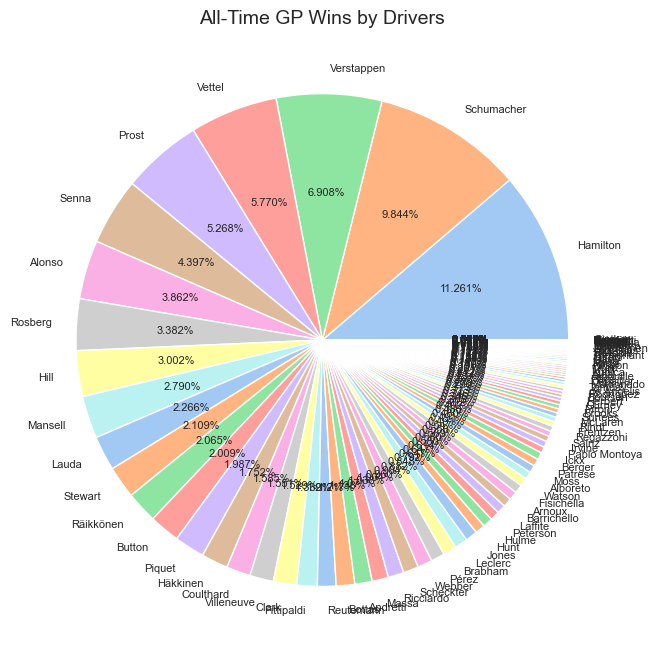

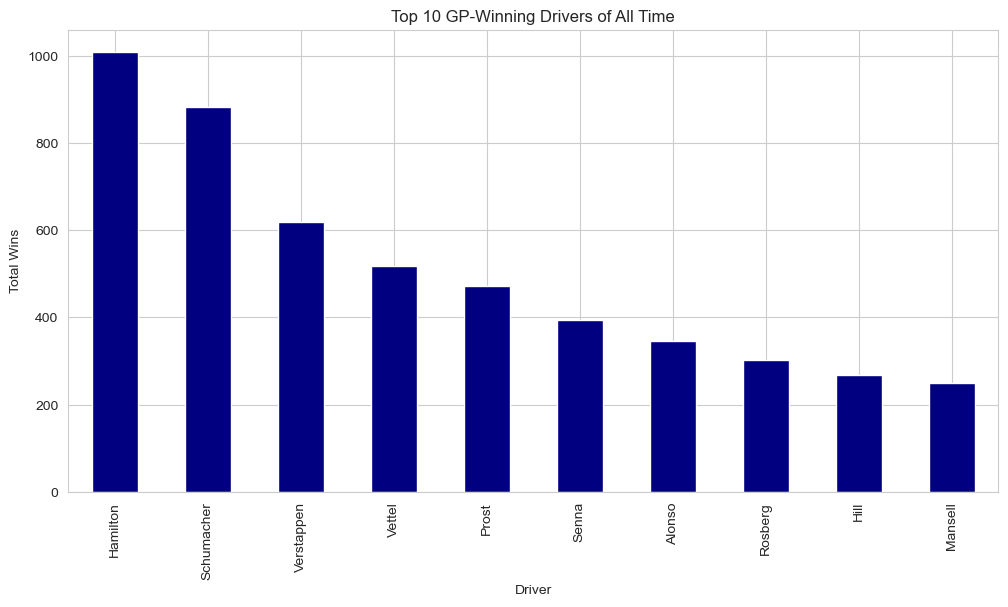

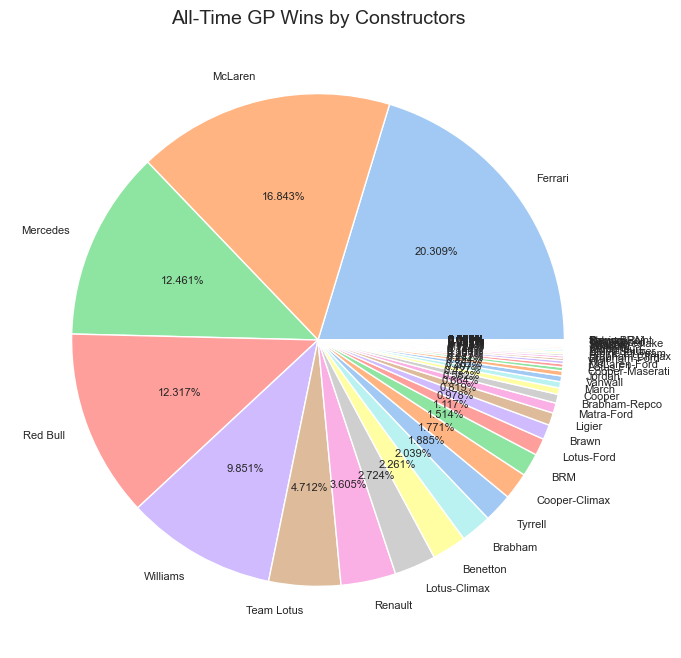

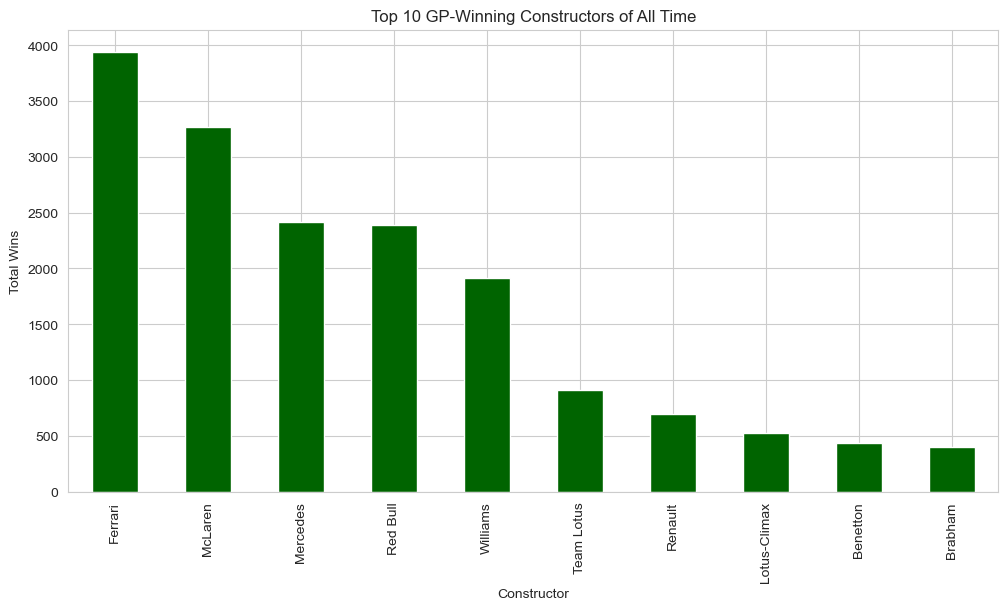

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

all_driver_wins = driver_df.groupby('Driver')['Driver Wins'].sum().sort_values(ascending=False)

all_constructor_wins = constructor_df.groupby('Constructor')['Constructor Wins'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
all_driver_wins.plot(kind='pie', autopct='%.3f%%', colors=sns.color_palette("pastel", len(all_driver_wins)), 
                     fontsize=8)
plt.title('All-Time GP Wins by Drivers', fontsize=14)
plt.ylabel('')  
plt.show()

plt.figure(figsize=(12, 6))
top_10_driver_wins.plot(kind='bar', color='navy')
plt.title('Top 10 GP-Winning Drivers of All Time')
plt.xlabel('Driver')
plt.ylabel('Total Wins')
plt.show()


plt.figure(figsize=(10, 8))
all_constructor_wins.plot(kind='pie', autopct='%.3f%%', colors=sns.color_palette("pastel", len(all_constructor_wins)),
                          fontsize=8)  
plt.title('All-Time GP Wins by Constructors', fontsize=14)
plt.ylabel('')  
plt.show()

plt.figure(figsize=(12, 6))
top_10_constructor_wins.plot(kind='bar', color='darkgreen')
plt.title('Top 10 GP-Winning Constructors of All Time')
plt.xlabel('Constructor')
plt.ylabel('Total Wins')
plt.show()

C:\Users\aryan\AppData\Local\Temp\ipykernel_23852\816135968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_df['Starting Grid'] = driver_df['Starting Grid'].replace('Pit Lane', -1)


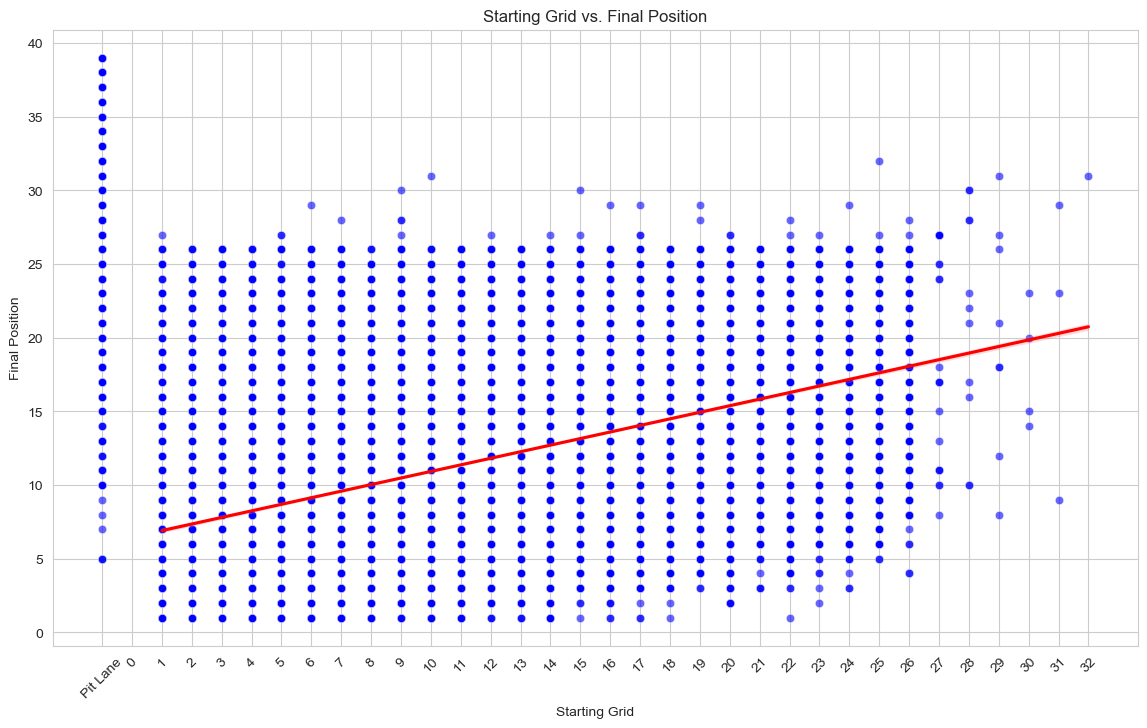

In [20]:
driver_df['Starting Grid'] = driver_df['Starting Grid'].replace('Pit Lane', -1)

plt.figure(figsize=(14, 8))
sns.scatterplot(data=driver_df, x='Starting Grid', y='Position', alpha=0.6, color='blue')
sns.regplot(data=driver_df[driver_df['Starting Grid'] != -1], x='Starting Grid', y='Position', scatter=False, color='red')
max_grid_position = int(driver_df['Starting Grid'].max())
xticks = list(range(-1, max_grid_position + 1))
xtick_labels = ['Pit Lane'] + list(range(0, max_grid_position + 1))
plt.xticks(ticks=xticks, labels=xtick_labels, rotation=45)
plt.title('Starting Grid vs. Final Position')
plt.xlabel('Starting Grid')
plt.ylabel('Final Position')
plt.show()

In [21]:
total_driver_points = driver_df.groupby('Driver')['Driver Race Points'].sum().reset_index()
top_10_driver_points = total_driver_points.sort_values(by='Driver Race Points', ascending=False).head(10)
print("Top 10 Drivers with Total Points Scored in Their Career:")
print(top_10_driver_points)

Top 10 Drivers with Total Points Scored in Their Career:
         Driver  Driver Race Points
212    Hamilton              4713.5
508      Vettel              3098.0
507  Verstappen              2761.5
12       Alonso              2304.0
450  Schumacher              1907.0
432   Räikkönen              1873.0
65       Bottas              1788.0
423     Rosberg              1754.0
400       Pérez              1552.0
417   Ricciardo              1319.0


In [22]:
total_constructor_points = constructor_df.groupby('Constructor')['Constructor Race Points'].sum().reset_index()
top_10_constructor_points = total_constructor_points.sort_values(by='Constructor Race Points', ascending=False).head(10)
print("\nTop 10 Constructors with Total Points Scored in Their Career:")
print(top_10_constructor_points)


Top 10 Constructors with Total Points Scored in Their Career:
     Constructor  Constructor Race Points
53       Ferrari                  20418.0
127     Red Bull                  15242.0
109     Mercedes                  14887.0
104      McLaren                  13514.0
157     Williams                   7315.0
128      Renault                   3526.0
57   Force India                   2196.0
145   Team Lotus                   2193.0
16      Benetton                   1675.0
83      Lotus F1                   1412.0


C:\Users\aryan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


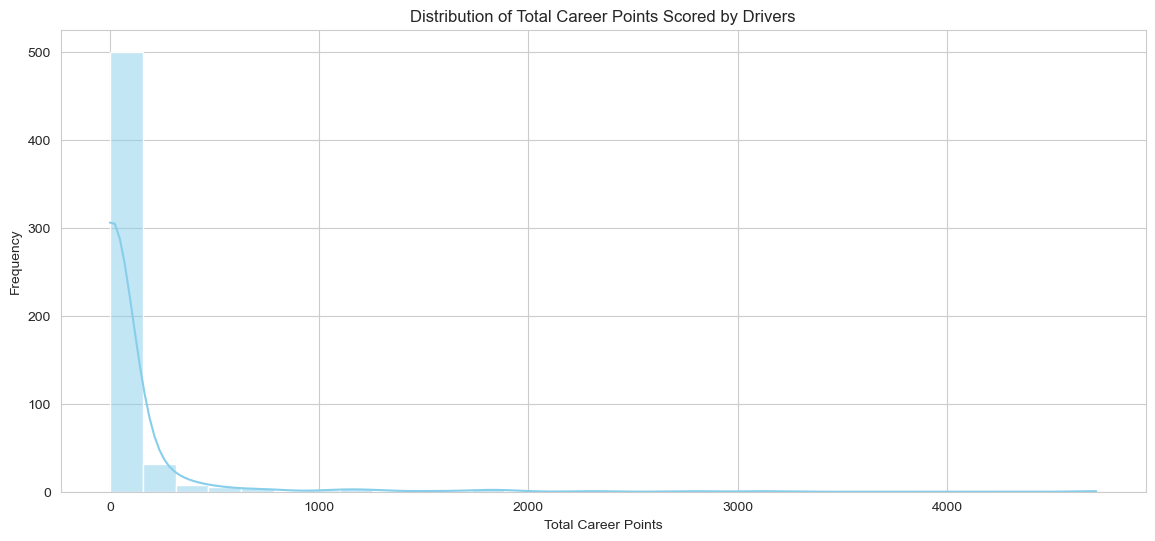

C:\Users\aryan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


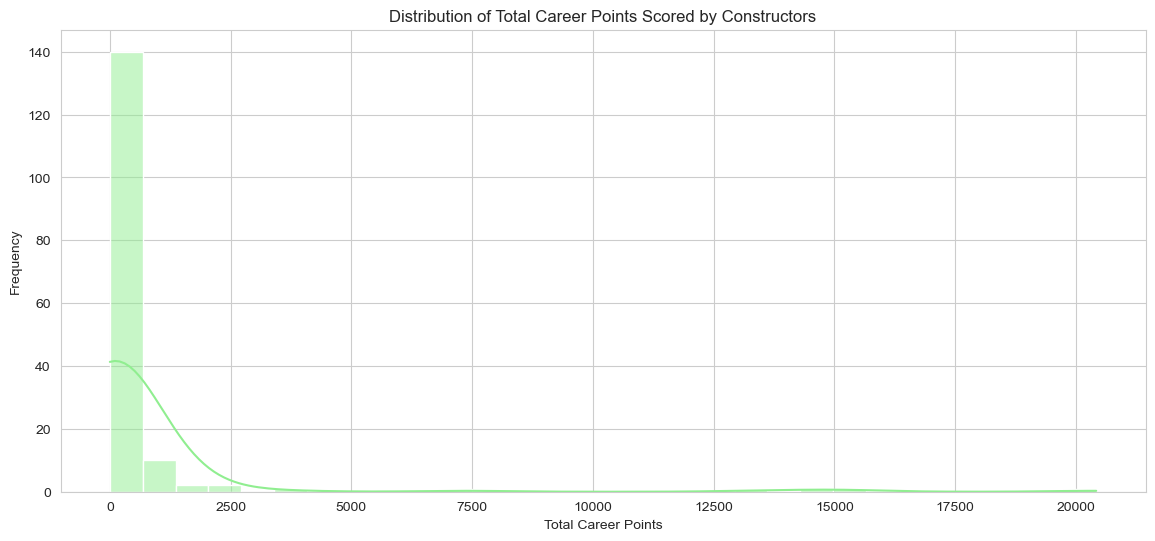

In [23]:
sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))
sns.histplot(total_driver_points['Driver Race Points'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Total Career Points Scored by Drivers')
plt.xlabel('Total Career Points')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(14, 6))
sns.histplot(total_constructor_points['Constructor Race Points'], bins=30, kde=True, color='lightgreen')
plt.title('Distribution of Total Career Points Scored by Constructors')
plt.xlabel('Total Career Points')
plt.ylabel('Frequency')
plt.show()

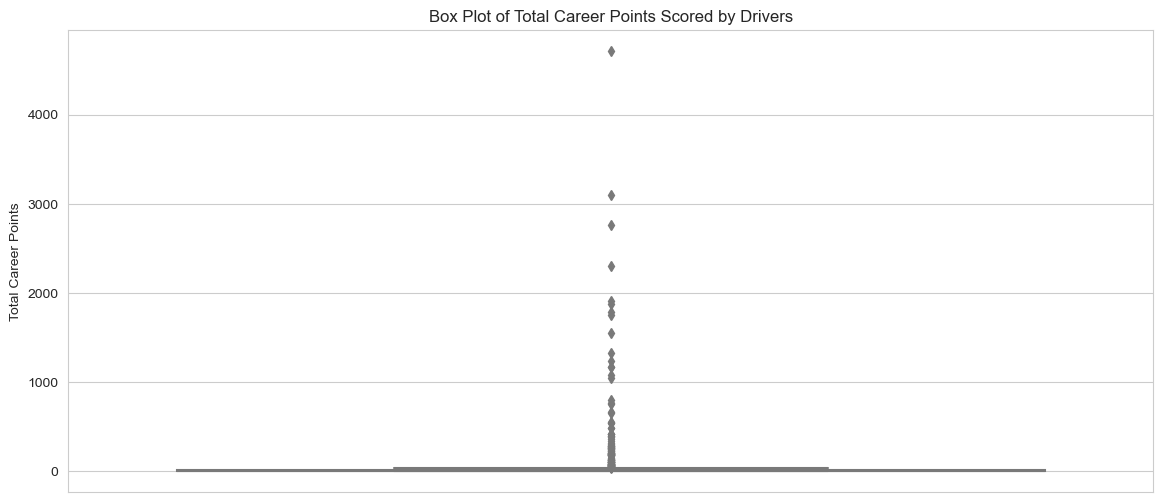

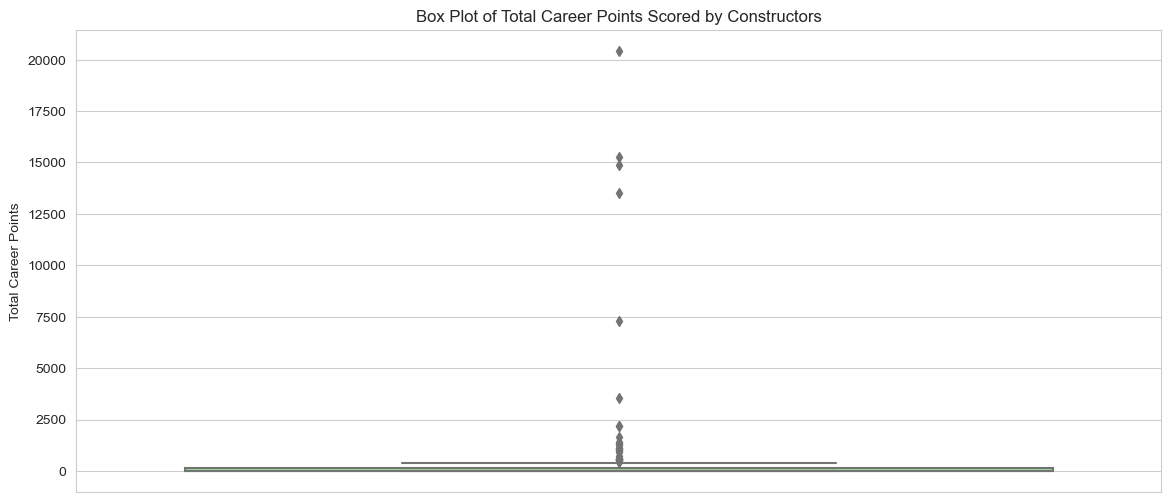

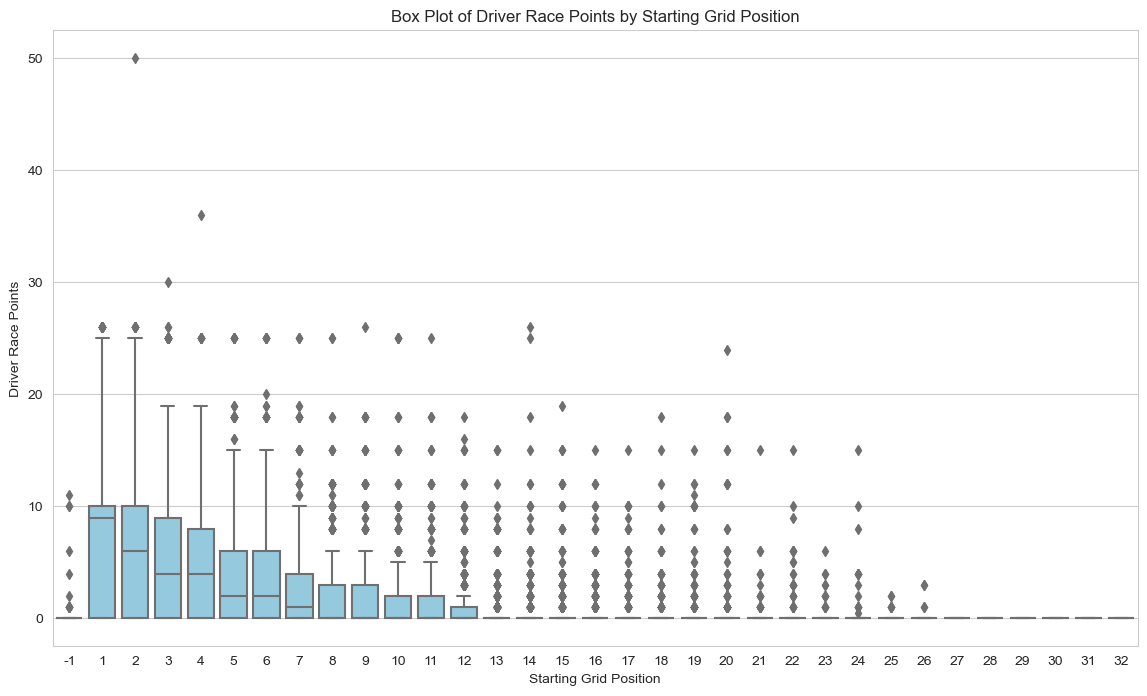

In [24]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=total_driver_points, y='Driver Race Points', color='lightblue')
plt.title('Box Plot of Total Career Points Scored by Drivers')
plt.ylabel('Total Career Points')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=total_constructor_points, y='Constructor Race Points', color='lightgreen')
plt.title('Box Plot of Total Career Points Scored by Constructors')
plt.ylabel('Total Career Points')
plt.show()

plt.figure(figsize=(14, 8))
sns.boxplot(data=driver_df, x='Starting Grid', y='Driver Race Points', color='skyblue')
plt.title('Box Plot of Driver Race Points by Starting Grid Position')
plt.xlabel('Starting Grid Position')
plt.ylabel('Driver Race Points')
plt.show()

USING MODERN DATA (2004-2024) AND PERFORMING EXPLORATORY DATA ANALYSIS.

In [25]:
columns_to_drop = ['raceId', 'driverId', 'constructorId', 'statusId', 'circuitId', 'nationality_x', 'nationality_y', 'laps', 'position']
modern_df = modern_df.drop(columns=[col for col in columns_to_drop if col in modern_df.columns])

rename_dict = {
    'name_x': 'Circuit',
    'name_y': 'Constructor',
    'round': 'Race No.',
    'surname': 'Driver',
    'points': 'Driver Race Points',
    'points_constructor_results': 'Constructor Race Points',
    'points_constructor_standings': 'Constructor Standings Points',
    'wins': 'Constructor Wins',
    'points_driver_standings': 'Driver Points',
    'position_driver_standings': 'Driver Standings',
    'wins_driver_standings': 'Driver Wins',
    'year': 'Year',
    'grid': 'Starting Grid',
    'fastestLap': 'Fastest Lap',
    'fastestLapTime': 'Fastest Lap Time',
    'fastestLapSpeed': 'Fastest Lap Speed',
    'rank': 'Rank',
    'positionOrder': 'Position',
    'milliseconds': 'Total Milliseconds'
}

modern_df.rename(columns={k: v for k, v in rename_dict.items() if k in modern_df.columns}, inplace=True)

ordered_columns = [
    'Year', 'Race No.', 'Circuit', 'Country', 'Position', 
    'Driver', 'Driver Race Points', 'Starting Grid', 'Driver Wins', 'Driver Points', 'Driver Standings',
    'Constructor', 'Constructor Race Points', 'Constructor Wins', 'Constructor Standings Points', 
    'Fastest Lap', 'Fastest Lap Time', 'Fastest Lap Speed', 'Rank', 'Total Milliseconds'
]

modern_df = modern_df[[col for col in ordered_columns if col in modern_df.columns]]

print("Reordered columns in modern_df:")
print(modern_df.head())

Reordered columns in modern_df:
   Year  Race No.                         Circuit  Position      Driver  \
0  2008         1  Albert Park Grand Prix Circuit         1    Hamilton   
1  2008         1  Albert Park Grand Prix Circuit         2    Heidfeld   
2  2008         1  Albert Park Grand Prix Circuit         3     Rosberg   
3  2008         1  Albert Park Grand Prix Circuit         4      Alonso   
4  2008         1  Albert Park Grand Prix Circuit         5  Kovalainen   

   Driver Race Points  Starting Grid  Driver Wins  Driver Points  \
0                10.0              1          1.0           10.0   
1                 8.0              5          0.0            8.0   
2                 6.0              7          0.0            6.0   
3                 5.0             11          0.0            5.0   
4                 4.0              3          0.0            4.0   

   Driver Standings Constructor  Constructor Race Points  Constructor Wins  \
0               1.0     McLare

In [26]:
driver_columns = [
    'Year', 'Race No.', 'Circuit', 'Country', 'Position',
    'Driver', 'Driver Race Points', 'Starting Grid', 'Driver Wins', 
    'Driver Points', 'Driver Standings', 'Fastest Lap', 'Fastest Lap Time',
    'Fastest Lap Speed', 'Rank', 'Total Milliseconds'
]

constructor_columns = [
    'Year', 'Race No.', 'Circuit', 'Country', 'Position',
    'Constructor', 'Constructor Race Points', 'Constructor Wins', 
    'Constructor Standings Points', 'Fastest Lap', 'Fastest Lap Time',
    'Fastest Lap Speed', 'Rank', 'Total Milliseconds'
]

driver_df_modern = modern_df[[col for col in driver_columns if col in modern_df.columns]]
constructor_df_modern = modern_df[[col for col in constructor_columns if col in modern_df.columns]]

constructor_df_modern['Constructor Standings'] = constructor_df_modern.groupby(['Year', 'Race No.'])['Constructor Race Points'].rank(method='min', ascending=False)

C:\Users\aryan\AppData\Local\Temp\ipykernel_23852\152103411.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  constructor_df_modern['Constructor Standings'] = constructor_df_modern.groupby(['Year', 'Race No.'])['Constructor Race Points'].rank(method='min', ascending=False)


In [27]:
driver_df_modern

,Year,Race No.,Circuit,Position,Driver,Driver Race Points,Starting Grid,Driver Wins,Driver Points,Driver Standings,Fastest Lap,Fastest Lap Time,Fastest Lap Speed,Rank,Total Milliseconds
0,2008,1,Albert Park Grand Prix Circuit,1,Hamilton,10.0,1,1.0,10.0,1.0,39,1:27.452,218.300,2,5690616
1,2008,1,Albert Park Grand Prix Circuit,2,Heidfeld,8.0,5,0.0,8.0,2.0,41,1:27.739,217.586,3,5696094
2,2008,1,Albert Park Grand Prix Circuit,3,Rosberg,6.0,7,0.0,6.0,3.0,41,1:28.090,216.719,5,5698779
3,2008,1,Albert Park Grand Prix Circuit,4,Alonso,5.0,11,0.0,5.0,4.0,58,1:28.603,215.464,7,5707797
4,2008,1,Albert Park Grand Prix Circuit,5,Kovalainen,4.0,3,0.0,4.0,5.0,43,1:27.418,218.385,1,5708630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26506,2024,12,Silverstone Circuit,8,Alonso,4.0,10,0.0,45.0,9.0,47,1:29.710,236.401,7,5010636
26507,2024,12,Silverstone Circuit,9,Albon,2.0,9,0.0,4.0,17.0,52,1:29.718,236.380,8,5015446
26508,2024,12,Silverstone Circuit,10,Tsunoda,1.0,13,0.0,20.0,12.0,43,1:30.229,235.041,14,5026362
26509,2024,12,Silverstone Circuit,11,Sargeant,0.0,12,0.0,0.0,20.0,42,1:29.972,235.713,12,5036019


In [28]:
constructor_df_modern.head()

,Year,Race No.,Circuit,Position,Constructor,Constructor Race Points,Constructor Wins,Constructor Standings Points,Fastest Lap,Fastest Lap Time,Fastest Lap Speed,Rank,Total Milliseconds,Constructor Standings
0,2008,1,Albert Park Grand Prix Circuit,1,McLaren,14.0,1.0,14.0,39,1:27.452,218.300,2,5690616,1.0
1,2008,1,Albert Park Grand Prix Circuit,2,BMW Sauber,8.0,0.0,8.0,41,1:27.739,217.586,3,5696094,4.0
2,2008,1,Albert Park Grand Prix Circuit,3,Williams,9.0,0.0,9.0,41,1:28.090,216.719,5,5698779,3.0
3,2008,1,Albert Park Grand Prix Circuit,4,Renault,5.0,0.0,5.0,58,1:28.603,215.464,7,5707797,5.0
4,2008,1,Albert Park Grand Prix Circuit,5,McLaren,14.0,1.0,14.0,43,1:27.418,218.385,1,5708630,1.0


In [29]:
max_speed = driver_df_modern['Fastest Lap Speed'].max()
min_speed = driver_df_modern['Fastest Lap Speed'].min()

print(f"Maximum Fastest Lap Speed: {max_speed} km/h")
print(f"Minimum Fastest Lap Speed: {min_speed} km/h")

Maximum Fastest Lap Speed: 257.320 km/h
Minimum Fastest Lap Speed: 148.589 km/h


In [30]:
max_time = driver_df_modern['Fastest Lap Time'].max()
min_time = driver_df_modern['Fastest Lap Time'].min()

print(f"Maximum Fastest Lap Time: {max_time} minutes")
print(f"Minimum Fastest Lap Time: {min_time} minutes")

Maximum Fastest Lap Time: 2:00.474 minutes
Minimum Fastest Lap Time: 0:55.404 minutes


C:\Users\aryan\AppData\Local\Temp\ipykernel_23852\2084224593.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_df_modern['Fastest Lap Speed'] = driver_df_modern['Fastest Lap Speed'].astype(float, errors='ignore')
C:\Users\aryan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


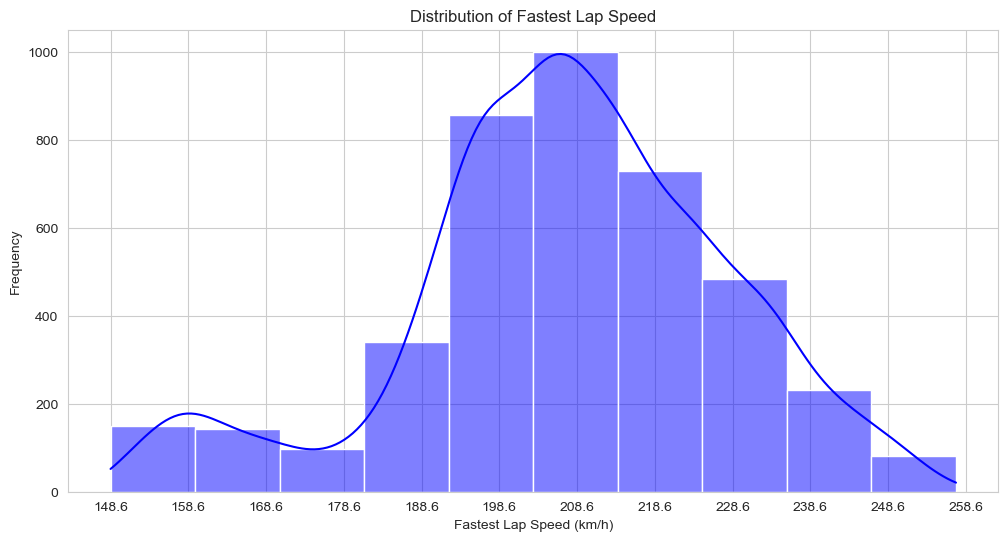

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
driver_df_modern['Fastest Lap Speed'] = driver_df_modern['Fastest Lap Speed'].astype(float, errors='ignore')
driver_df_modern.loc[:, 'Fastest Lap Speed'] = driver_df_modern['Fastest Lap Speed'].replace([float('inf'), -float('inf')], float('nan'))
driver_df_modern = driver_df_modern.dropna(subset=['Fastest Lap Speed'])

plt.figure(figsize=(12, 6))

sns.histplot(driver_df_modern['Fastest Lap Speed'], bins=10, kde=True, color='blue')
plt.title('Distribution of Fastest Lap Speed')
plt.xlabel('Fastest Lap Speed (km/h)')
plt.ylabel('Frequency')

x_ticks = np.arange(driver_df_modern['Fastest Lap Speed'].min(), 
                    driver_df_modern['Fastest Lap Speed'].max() + 5, 10)

plt.xticks(x_ticks, fontsize=10)
plt.show()

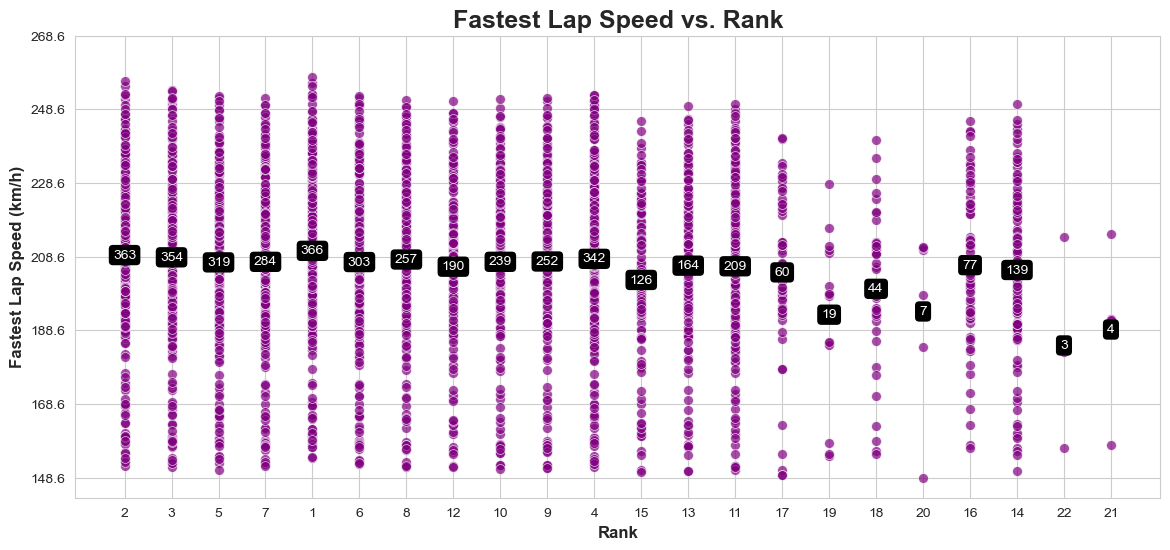

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

driver_df_modern['Fastest Lap Speed'] = pd.to_numeric(driver_df_modern['Fastest Lap Speed'], errors='coerce')

sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))

sns.scatterplot(data=driver_df_modern, x='Rank', y='Fastest Lap Speed', alpha=0.7, color='purple', s=50)

plt.title('Fastest Lap Speed vs. Rank', fontsize=18, weight='bold')
plt.xlabel('Rank', fontsize=12, weight='bold')
plt.ylabel('Fastest Lap Speed (km/h)', fontsize=12, weight='bold')

plt.xticks(fontsize=10)

y_ticks = np.arange(driver_df_modern['Fastest Lap Speed'].min(), 
                    driver_df_modern['Fastest Lap Speed'].max() + 27, 
                    20)

plt.yticks(y_ticks, fontsize=10)

for rank in driver_df_modern['Rank'].unique():
    count = (driver_df_modern['Rank'] == rank).sum()
    avg_y = driver_df_modern[driver_df_modern['Rank'] == rank]['Fastest Lap Speed'].mean()
    plt.text(rank, avg_y, f'{count}', color='white', fontsize=10, ha='center', va='center',
             bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.3'))

plt.show()

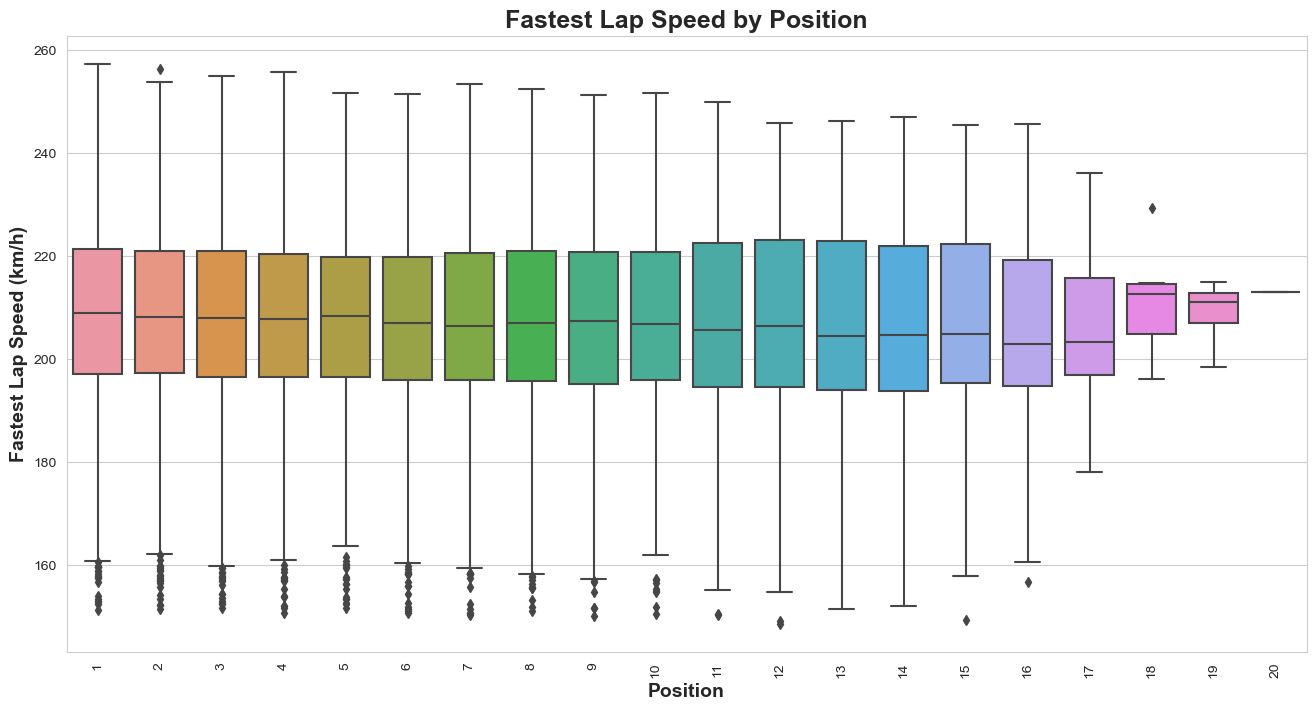

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(16, 8))
sns.boxplot(data=driver_df_modern, x='Position', y='Fastest Lap Speed')
plt.title('Fastest Lap Speed by Position', fontsize=18, weight='bold')
plt.xlabel('Position', fontsize=14, weight='bold')
plt.ylabel('Fastest Lap Speed (km/h)', fontsize=14, weight='bold')
plt.xticks(rotation=90)
plt.show()

In [34]:
driver_df_modern['Fastest Lap Time (seconds)'] = driver_df_modern['Fastest Lap Time'].apply(
    lambda x: sum(float(t) * 60 ** i for i, t in enumerate(reversed(x.split(':')))) if isinstance(x, str) else np.nan
)

correlation_matrix = driver_df_modern[['Fastest Lap', 'Fastest Lap Speed', 'Rank', 'Total Milliseconds']].corr()
print("Correlation Matrix:")
correlation_matrix

Correlation Matrix:


,Fastest Lap,Fastest Lap Speed,Rank,Total Milliseconds
Fastest Lap,1.000000,-0.148034,-0.035819,0.118963
Fastest Lap Speed,-0.148034,1.000000,-0.088942,-0.483307
Rank,-0.035819,-0.088942,1.000000,0.070795
Total Milliseconds,0.118963,-0.483307,0.070795,1.000000


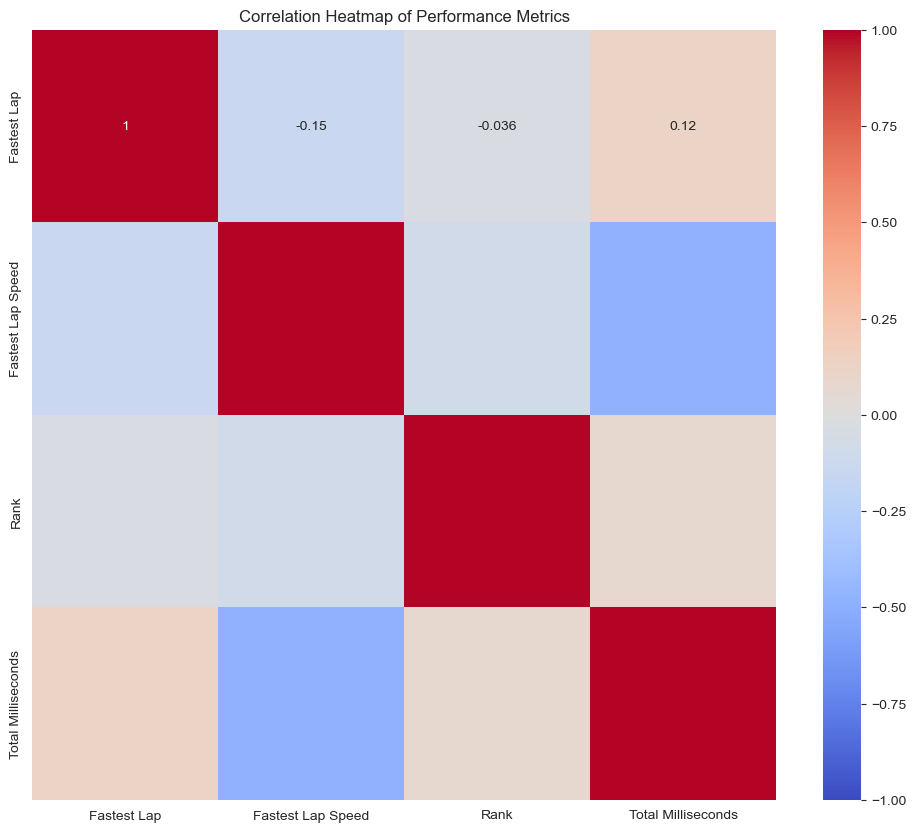

In [35]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Performance Metrics')
plt.show()

PREPROCESSING DATA FOR MACHINE LEARNING TRAINING OF CONSTRUCTOR CHAMPIONSHIP WINNERS.

In [36]:
print("Data types of columns in constructor_df_modern:")
print(constructor_df_modern.dtypes)

numeric_cols = constructor_df_modern.select_dtypes(include=[np.number]).columns.tolist()
agg_dict = {col: 'mean' for col in numeric_cols if col not in ['Year', 'Constructor']}
agg_dict.update({
    'Constructor Race Points': 'sum',
    'Constructor Wins': 'sum',
    'Constructor Standings Points': 'sum'
})

constructor_season_data = constructor_df_modern.groupby(['Year', 'Constructor']).agg(agg_dict).reset_index()
print("Aggregated constructor season data:")
print(constructor_season_data.head())

Data types of columns in constructor_df_modern:
Year                              int64
Race No.                          int64
Circuit                          object
Position                          int64
Constructor                      object
Constructor Race Points         float64
Constructor Wins                float64
Constructor Standings Points    float64
Fastest Lap                      object
Fastest Lap Time                 object
Fastest Lap Speed                object
Rank                             object
Total Milliseconds               object
Constructor Standings           float64
dtype: object
Aggregated constructor season data:
   Year Constructor   Race No.  Position  Constructor Race Points  \
0  2004         BAR  10.043478  4.260870                    176.0   
1  2004     Ferrari   9.181818  2.333333                    498.0   
2  2004      Jaguar  11.571429  7.857143                     12.0   
3  2004     McLaren  12.769231  5.076923                     88.0 

In [37]:
columns_to_check = ['Fastest Lap', 'Fastest Lap Time', 'Rank', 'Total Milliseconds']
non_numeric_values = {
    col: constructor_df_modern[col][~pd.to_numeric(constructor_df_modern[col], errors='coerce').notnull()].unique()
    for col in columns_to_check
}

for col, values in non_numeric_values.items():
    print(f"Non-numeric values in '{col}': {values}")

Non-numeric values in 'Fastest Lap': []
Non-numeric values in 'Fastest Lap Time': ['1:27.452' '1:27.739' '1:28.090' ... '1:30.229' '1:29.972' '1:30.093']
Non-numeric values in 'Rank': []
Non-numeric values in 'Total Milliseconds': []


In [38]:
def convert_time_to_seconds(time_str):
    if isinstance(time_str, str):
        time_parts = time_str.split(':')
        minutes = int(time_parts[0])
        seconds = float(time_parts[1])
        total_seconds = minutes * 60 + seconds
        return total_seconds
    return np.nan

constructor_df_modern['Fastest Lap Time'] = constructor_df_modern['Fastest Lap Time'].apply(convert_time_to_seconds)
constructor_df_modern['Fastest Lap'] = pd.to_numeric(constructor_df_modern['Fastest Lap'], errors='coerce')
constructor_df_modern['Rank'] = pd.to_numeric(constructor_df_modern['Rank'], errors='coerce')
constructor_df_modern['Total Milliseconds'] = pd.to_numeric(constructor_df_modern['Total Milliseconds'], errors='coerce')
constructor_df_modern['Fastest Lap Speed'] = pd.to_numeric(constructor_df_modern['Fastest Lap Speed'], errors='coerce')

print("Updated data types in constructor_df_modern:")
print(constructor_df_modern.dtypes)

columns_to_check = ['Fastest Lap', 'Fastest Lap Time', 'Rank', 'Total Milliseconds', 'Fastest Lap Speed']
non_numeric_values = {
    col: constructor_df_modern[col][~pd.to_numeric(constructor_df_modern[col], errors='coerce').notnull()].unique()
    for col in columns_to_check
}

for col, values in non_numeric_values.items():
    print(f"Non-numeric values in '{col}': {values}")

print("\nRows with NaN in 'Fastest Lap Speed' after conversion:")
print(constructor_df_modern[constructor_df_modern['Fastest Lap Speed'].isna()])

Updated data types in constructor_df_modern:
Year                              int64
Race No.                          int64
Circuit                          object
Position                          int64
Constructor                      object
Constructor Race Points         float64
Constructor Wins                float64
Constructor Standings Points    float64
Fastest Lap                       int64
Fastest Lap Time                float64
Fastest Lap Speed               float64
Rank                              int64
Total Milliseconds                int64
Constructor Standings           float64
dtype: object
Non-numeric values in 'Fastest Lap': []
Non-numeric values in 'Fastest Lap Time': []
Non-numeric values in 'Rank': []
Non-numeric values in 'Total Milliseconds': []
Non-numeric values in 'Fastest Lap Speed': []

Rows with NaN in 'Fastest Lap Speed' after conversion:
Empty DataFrame
Columns: [Year, Race No., Circuit, Position, Constructor, Constructor Race Points, Constructor Win

C:\Users\aryan\AppData\Local\Temp\ipykernel_23852\3307852033.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  constructor_df_modern['Fastest Lap Time'] = constructor_df_modern['Fastest Lap Time'].apply(convert_time_to_seconds)
C:\Users\aryan\AppData\Local\Temp\ipykernel_23852\3307852033.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  constructor_df_modern['Fastest Lap'] = pd.to_numeric(constructor_df_modern['Fastest Lap'], errors='coerce')
C:\Users\aryan\AppData\Local\Temp\ipykernel_23852\330785203

TRAINING THE MODEL USING MODERN DATA.

In [39]:
constructor_season_data = constructor_df_modern.groupby(['Year', 'Constructor']).agg({
    'Constructor Race Points': 'sum',
    'Constructor Wins': 'sum',
    'Constructor Standings Points': 'sum',
    'Fastest Lap': 'mean',
    'Fastest Lap Time': 'count',
    'Fastest Lap Speed': 'mean',
    'Rank': 'mean',
    'Total Milliseconds': 'mean',
    'Position': 'mean'
}).reset_index()

constructor_season_data.rename(columns={'Fastest Lap Time': 'Races Participated'}, inplace=True)
target_constructor = 'Constructor Standings'

constructor_season_data = constructor_season_data.merge(
    constructor_df_modern[['Year', 'Constructor', target_constructor]].drop_duplicates(),
    on=['Year', 'Constructor'],
    how='left'
)

constructor_season_data = constructor_season_data.dropna(subset=[target_constructor])

X_constructor = constructor_season_data.drop(columns=['Year', 'Constructor', target_constructor])
y_constructor = constructor_season_data[target_constructor]

train_years_constructor = constructor_season_data['Year'] < constructor_season_data['Year'].max()
test_years_constructor = ~train_years_constructor

X_train_constructor, X_test_constructor = X_constructor[train_years_constructor], X_constructor[test_years_constructor]
y_train_constructor, y_test_constructor = y_constructor[train_years_constructor], y_constructor[test_years_constructor]

model_constructor = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_constructor.fit(X_train_constructor, y_train_constructor)

y_pred_constructor = model_constructor.predict(X_test_constructor)
y_pred_constructor_rounded = np.round(y_pred_constructor)

mse_constructor = mean_squared_error(y_test_constructor, y_pred_constructor_rounded)
r2_constructor = r2_score(y_test_constructor, y_pred_constructor_rounded)

print(f"Mean Squared Error for Constructor Model: {mse_constructor:.2f}")
print(f"R-squared Score for Constructor Model: {r2_constructor:.2f}")

comparison_df_constructor = pd.DataFrame({
    'Actual Constructor Standings': y_test_constructor,
    'Predicted Constructor Standings': y_pred_constructor_rounded
}, index=X_test_constructor.index)

print("Predicted vs Actual Constructor Standings:")
print(comparison_df_constructor)

Mean Squared Error for Constructor Model: 5.36
R-squared Score for Constructor Model: 0.69
Predicted vs Actual Constructor Standings:
      Actual Constructor Standings  Predicted Constructor Standings
1131                          13.0                             10.0
1132                          15.0                             10.0
1133                          10.0                             10.0
1134                           9.0                             10.0
1135                          11.0                             10.0
1136                           9.0                              8.0
1137                           7.0                              8.0
1138                           5.0                              8.0
1139                          11.0                              8.0
1140                           6.0                              8.0
1141                           3.0                              5.0
1142                           1.0                

TRAINING THE MODEL USING ALL DATA AT HAND.

In [40]:
constructor_df = constructor_df[['Year', 'Race No.', 'Circuit', 'Country', 'Position', 'Constructor',
                                 'Constructor Race Points', 'Constructor Wins', 'Constructor Standings']]

constructor_season_data = constructor_df.groupby(['Year', 'Constructor']).agg({
    'Constructor Race Points': 'sum',
    'Constructor Wins': 'sum',
    'Position': 'mean'
}).reset_index()

target_constructor = 'Constructor Standings'

constructor_season_data = constructor_season_data.merge(
    constructor_df[['Year', 'Constructor', target_constructor]].drop_duplicates(),
    on=['Year', 'Constructor'],
    how='left'
)

constructor_season_data = constructor_season_data.dropna(subset=[target_constructor])

X_constructor = constructor_season_data.drop(columns=['Year', 'Constructor', target_constructor])
y_constructor = constructor_season_data[target_constructor]

train_years_constructor = constructor_season_data['Year'] < constructor_season_data['Year'].max()
test_years_constructor = ~train_years_constructor

X_train_constructor, X_test_constructor = X_constructor[train_years_constructor], X_constructor[test_years_constructor]
y_train_constructor, y_test_constructor = y_constructor[train_years_constructor], y_constructor[test_years_constructor]

model_constructor = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_constructor.fit(X_train_constructor, y_train_constructor)

y_pred_constructor = np.round(model_constructor.predict(X_test_constructor))

mse_constructor = mean_squared_error(y_test_constructor, y_pred_constructor)
r2_constructor = r2_score(y_test_constructor, y_pred_constructor)

print(f"Mean Squared Error for Constructor Model: {mse_constructor:.2f}")
print(f"R-squared Score for Constructor Model: {r2_constructor:.2f}")

comparison_df_constructor = pd.DataFrame({
    'Actual Constructor Standings': y_test_constructor,
    'Predicted Constructor Standings': y_pred_constructor
}, index=X_test_constructor.index)
print("Predicted vs Actual Constructor Standings:")
print(comparison_df_constructor)

Mean Squared Error for Constructor Model: 1.21
R-squared Score for Constructor Model: 0.76
Predicted vs Actual Constructor Standings:
      Actual Constructor Standings  Predicted Constructor Standings
3237                             6                              7.0
3238                             7                              7.0
3239                             8                              7.0
3240                             5                              6.0
3241                             2                              3.0
3242                             6                              6.0
3243                             7                              6.0
3244                             8                              6.0
3245                             4                              3.0
3246                             3                              3.0
3247                             3                              3.0
3248                             4                

HYPERPARAMETER TUNING.

In [41]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_constructor, y_train_constructor)

best_model_constructor = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_pred_constructor = np.round(best_model_constructor.predict(X_test_constructor))

mse_constructor = mean_squared_error(y_test_constructor, y_pred_constructor)
r2_constructor = r2_score(y_test_constructor, y_pred_constructor)

print(f"Mean Squared Error for Best Constructor Model: {mse_constructor:.2f}")
print(f"R-squared Score for Best Constructor Model: {r2_constructor:.2f}")

comparison_df_constructor = pd.DataFrame({
    'Actual Constructor Standings': y_test_constructor,
    'Predicted Constructor Standings': y_pred_constructor
}, index=X_test_constructor.index)
print("Predicted vs Actual Constructor Standings:")
print(comparison_df_constructor)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Mean Squared Error for Best Constructor Model: 1.17
R-squared Score for Best Constructor Model: 0.77
Predicted vs Actual Constructor Standings:
      Actual Constructor Standings  Predicted Constructor Standings
3237                             6                              7.0
3238                             7                              7.0
3239                             8                              7.0
3240                             5                              5.0
3241                             2                              3.0
3242                             6                              6.0
3243                             7                              6.0
3244                             8                              6.0
3245                             4                          

FEATURE IMPORTANCE ANALYSIS.

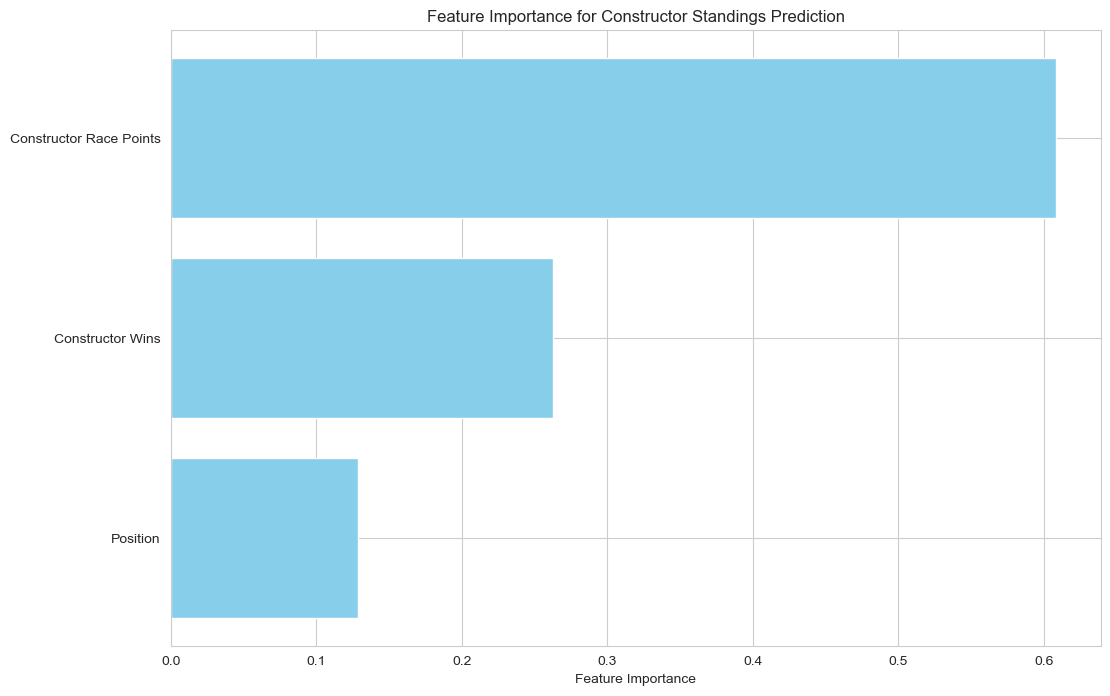

In [42]:
feature_importances = model_constructor.feature_importances_
feature_names = X_train_constructor.columns
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Constructor Standings Prediction')
plt.gca().invert_yaxis()
plt.show()

Mean Absolute Error for Constructor Model: 0.83
Mean Squared Error for Constructor Model: 1.17
Root Mean Squared Error for Constructor Model: 1.08
R-squared Score for Constructor Model: 0.77


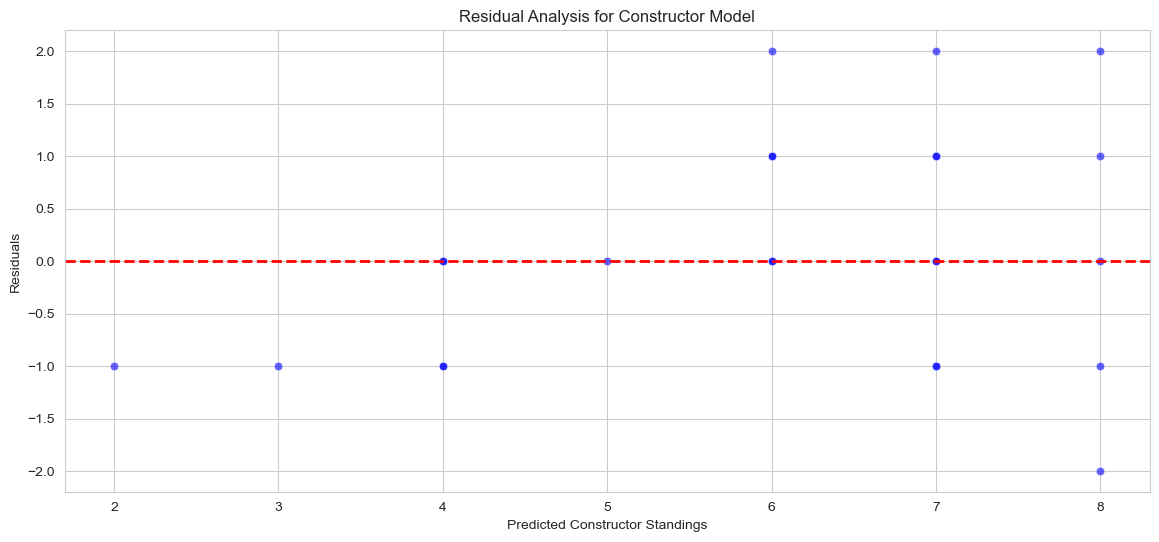

C:\Users\aryan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


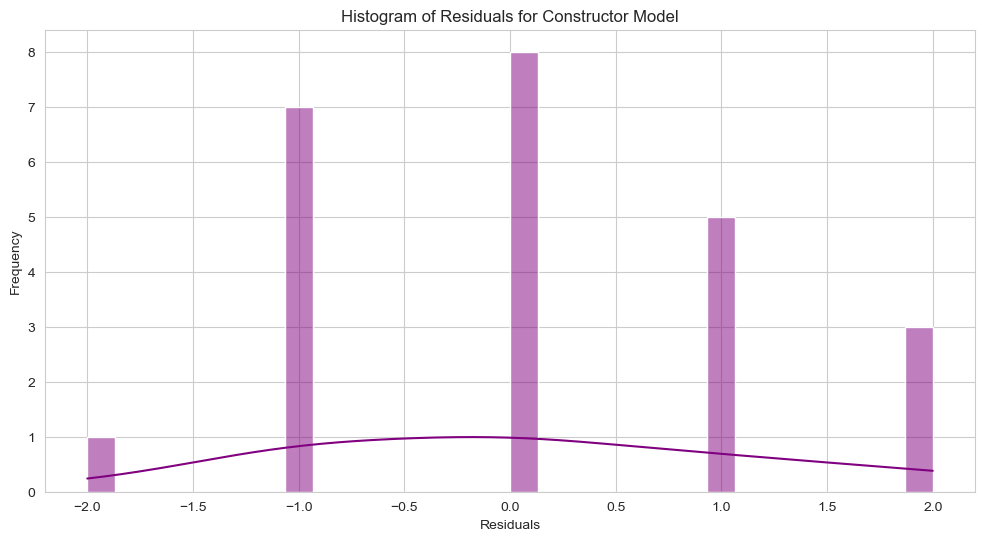

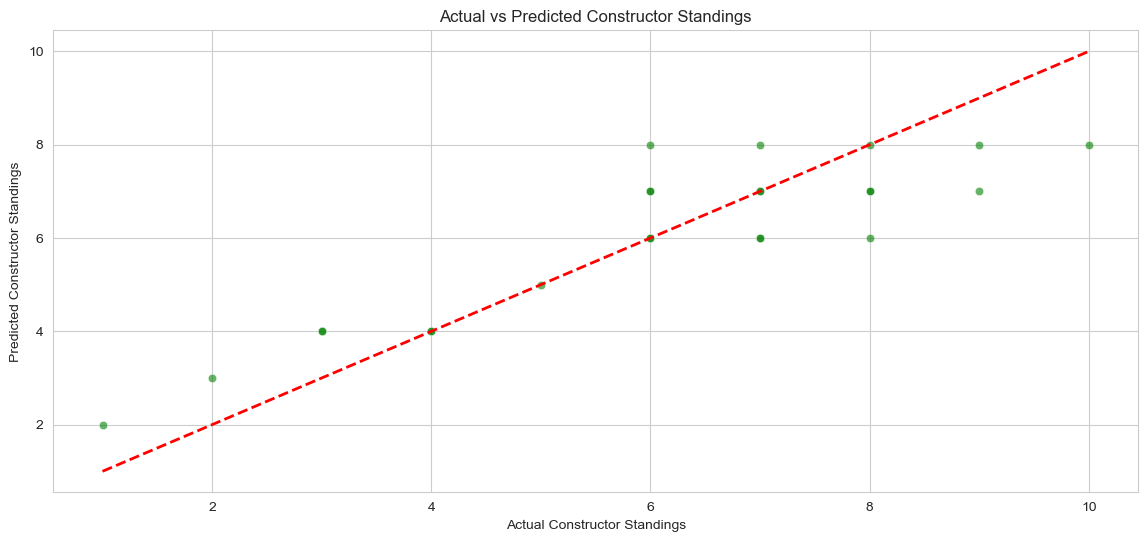

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure predictions align with the test set
if len(y_pred_constructor) > len(y_test_constructor):
    y_pred_constructor = y_pred_constructor[:len(y_test_constructor)]
elif len(y_pred_constructor) < len(y_test_constructor):
    print("The number of predictions is less than the number of actual targets. Please check the data split.")

# Convert predictions to a Series with the same index as the test set
y_pred_constructor = pd.Series(y_pred_constructor, index=y_test_constructor.index)

# Calculate residuals
residuals = y_test_constructor - y_pred_constructor

# Mean Absolute Error
mae_constructor = mean_absolute_error(y_test_constructor, y_pred_constructor)
print(f"Mean Absolute Error for Constructor Model: {mae_constructor:.2f}")

# Mean Squared Error
mse_constructor = mean_squared_error(y_test_constructor, y_pred_constructor)
print(f"Mean Squared Error for Constructor Model: {mse_constructor:.2f}")

# Root Mean Squared Error
rmse_constructor = np.sqrt(mse_constructor)
print(f"Root Mean Squared Error for Constructor Model: {rmse_constructor:.2f}")

# R-squared Score
r2_constructor = r2_score(y_test_constructor, y_pred_constructor)
print(f"R-squared Score for Constructor Model: {r2_constructor:.2f}")

# Residual analysis plot
plt.figure(figsize=(14, 6))
sns.scatterplot(x=y_pred_constructor, y=residuals, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Analysis for Constructor Model')
plt.xlabel('Predicted Constructor Standings')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals (error distribution)
plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.title('Histogram of Residuals for Constructor Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Actual vs Predicted plot
plt.figure(figsize=(14, 6))
sns.scatterplot(x=y_test_constructor, y=y_pred_constructor, color='green', alpha=0.6)
plt.plot([y_test_constructor.min(), y_test_constructor.max()],
         [y_test_constructor.min(), y_test_constructor.max()], 'r--', linewidth=2)
plt.title('Actual vs Predicted Constructor Standings')
plt.xlabel('Actual Constructor Standings')
plt.ylabel('Predicted Constructor Standings')
plt.show()
